**NFT Robo Predictor Tool- Prototype**

OpenSea, currently the world's largest marketplace for NFTs is an obvious source of sales information on NFTs.

The below framework makes use of the OpenSea API to construct machine learning models that can predict NFT sales outcomes.  We focused on the fundamental metrics best organized by OpenSea - Collection Group, Coloring, Traits, and Sales History.

Using these values, the below framework is able to produce multiple models with consistent accuracy.

This framework can expand in future iterations to include natural language processing of NFT 'traits' and 'names' as well as image analysis for pattern recognition.

**IMPORTS**

In [168]:
# multiple import packages necessary for data cleaning, model creation, and analysis.

import numpy as np
import pandas as pd
import requests
import json
from pprint import pprint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import linear_model, metrics
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras.utils.vis_utils import plot_model



In [2]:
# Upload collections_list.xlsx to Colab.  This file is a list of the 100 most popular NFT collections on OpenSea.
from google.colab import files

csv_file = files.upload()

Saving collections_list.xlsx to collections_list.xlsx


In [3]:
# Read the collections_list.xlsx file from the Resources folder into a Pandas DataFrame
collections_df = pd.read_excel("collections_list.xlsx",'main')

# Review the DataFrame
#collections_df

**Using the Collection List to Call the API data**

In [4]:
#converting the list of collections into a list so we can modify the names to fit the API call
collection_list = [x for x in collections_df['Name']]

In [5]:
#collection_list_two updates the list by replacing spacing with a dash mark.  This is necessary to fit the API
collection_list_two = []
for i in collection_list:
  collection_list_two.append(i.replace(" ", "-"))
 

In [6]:
#collection_list_three updates the previous list to make sure everyting is lowercase.  This is necessary for the API call
collection_list_three = []
for i in collection_list_two:
  collection_list_three.append(i.lower())

In [7]:
#to call the API, we first set an empty DataFrame object.  We then loop through the list of 100 collections and call approximately 50 NFT assets each. 
#the API as a 50 at a time call limit, but we can get around this by looping through multiple 50 NFT api calls.

df = pd.DataFrame()
for collection in collection_list_three:
  
  url = "https://api.opensea.io/api/v1/assets?order_by=sale_count&order_direction=desc&offset=0&limit=50&collection=" + collection

  JSONContent = requests.get(url).json()

  content = json.dumps(JSONContent, indent = 2, sort_keys=True)
#converting JSON content and appending into the once empty pandas dataframe
  JSONContent.keys()

  df = df.append(JSONContent["assets"])

**Cleaning up the API data into usable Dataframes for Model Creation**

In [ ]:
#df

In [8]:
collection_df = df['collection'].apply(pd.Series)
#collection_df

In [9]:
#Collection Name
collection_name = collection_df["name"].apply(pd.Series)
collection_name.columns = ['Collection Name']
#collection_name

In [10]:
last_sale_df = df['last_sale'].apply(pd.Series)
#last_sale_df

In [11]:
#Last Sale Price in ETH
total_price = last_sale_df['total_price'].apply(pd.Series)
total_price.columns = ['Last Sale Price ETH']
total_price = total_price.astype(float)* 0.000000000000000001
total_price = total_price.fillna(0)
#total_price

In [14]:
background_color = df['background_color']
#background_color

In [15]:
df['traits']

0     [{'trait_type': 'Strength', 'value': 3, 'displ...
1     [{'trait_type': 'Eyes', 'value': 'Half Open (A...
2     [{'trait_type': 'Extra', 'value': '0N1 Logo Pi...
3     [{'trait_type': 'Extra', 'value': '0N1 Logo Pi...
4     [{'trait_type': 'Face', 'value': 'Void', 'disp...
                            ...                        
46    [{'trait_type': 'breed_type', 'value': 'genesi...
47    [{'trait_type': 'breed_type', 'value': 'genesi...
48    [{'trait_type': 'breed_type', 'value': 'genesi...
49    [{'trait_type': 'bloodline', 'value': 'Nakamot...
0     [{'trait_type': 'background', 'value': 'Ocean'...
Name: traits, Length: 2852, dtype: object

**'Traits' Section - Important Notes !!!READ!!!**

The next three cells may require manual updating everytime you refresh the ABOVE api call.  - Everytime an API call is made, different maximum amounts of NFT traits are generated.  The below 3 cells organize those trait lists into a cleaned dataframe for counting.  

ToDo : Run the below cell and see if you get an error message.  If not - do nothing and proceed.  If so, the message will say "expected" traits number etc.  You can proceed by updated the amount of train columns in the 3 below cells.

In most cases API calls have had between 15 and 25 traits.

Future versions will automate this process.

In [16]:
#Creates New Columns and Lists Asset Traits
traits = df['traits'].apply(pd.Series)
traits.columns = ['Trait1', 'Trait2', 'Trait3', 'Trait4',
                  'Trait5', 'Trait6', 'Trait7', 'Trait8',
                  'Trait9', 'Trait10', 'Trait11', 'Trait12',
                  'Trait13', 'Trait14', 'Trait15']

traits

,Trait1,Trait2,Trait3,Trait4,Trait5,Trait6,Trait7,Trait8,Trait9,Trait10,Trait11,Trait12,Trait13,Trait14,Trait15
0,"{'trait_type': 'Strength', 'value': 3, 'displa...","{'trait_type': 'Spirit', 'value': 1, 'display_...","{'trait_type': 'Background', 'value': 'Citrine...","{'trait_type': 'Eyes', 'value': 'Open (Citrine...","{'trait_type': 'Style', 'value': 3, 'display_t...","{'trait_type': 'Mouth', 'value': 'Neutral', 'd...","{'trait_type': 'Head', 'value': 'Headphones (P...","{'trait_type': 'Hair', 'value': 'Bob (Rose)', ...","{'trait_type': 'Type', 'value': 'Y0K-A1', 'dis...","{'trait_type': 'Wear', 'value': 'Thermal Hoodi...","{'trait_type': 'Body', 'value': 'Jasper', 'dis...","{'trait_type': 'Extra', 'value': 'Void', 'disp...","{'trait_type': 'Face', 'value': 'Glasses (Obsi...",NaN,NaN
1,"{'trait_type': 'Eyes', 'value': 'Half Open (Az...","{'trait_type': 'Spirit', 'value': 2, 'display_...","{'trait_type': 'Style', 'value': 3, 'display_t...","{'trait_type': 'Strength', 'value': 5, 'displa...","{'trait_type': 'Body', 'value': 'Azurite', 'di...","{'trait_type': 'Face', 'value': 'Bandaid', 'di...","{'trait_type': 'Head', 'value': 'Void', 'displ...","{'trait_type': 'Wear', 'value': 'Bomber Jacket...","{'trait_type': 'Type', 'value': 'Y0K-A1', 'dis...","{'trait_type': 'Background', 'value': 'Azurite...","{'trait_type': 'Extra', 'value': 'Void', 'disp...","{'trait_type': 'Mouth', 'value': 'Smirk', 'dis...","{'trait_type': 'Hair', 'value': 'Spiky (Obsidi...",NaN,NaN
2,"{'trait_type': 'Extra', 'value': '0N1 Logo Pin...","{'trait_type': 'Hair', 'value': 'Spiky (Citrin...","{'trait_type': 'Face', 'value': 'PR Mask (Jasp...","{'trait_type': 'Style', 'value': 5, 'display_t...","{'trait_type': 'Body', 'value': 'Azurite', 'di...","{'trait_type': 'Mouth', 'value': 'Neutral', 'd...","{'trait_type': 'Spirit', 'value': 4, 'display_...","{'trait_type': 'Head', 'value': 'Headphones (P...","{'trait_type': 'Strength', 'value': 4, 'displa...","{'trait_type': 'Type', 'value': 'Y0K-A1', 'dis...","{'trait_type': 'Background', 'value': 'Azurite...","{'trait_type': 'Wear', 'value': 'Thermal Hoodi...","{'trait_type': 'Eyes', 'value': 'Squint (Azuri...",NaN,NaN
3,"{'trait_type': 'Extra', 'value': '0N1 Logo Pin...","{'trait_type': 'Wear', 'value': 'Kimono (Rose)...","{'trait_type': 'Background', 'value': 'Citrine...","{'trait_type': 'Head', 'value': 'Headphones (T...","{'trait_type': 'Style', 'value': 3, 'display_t...","{'trait_type': 'Eyes', 'value': 'Half Open (Ci...","{'trait_type': 'Body', 'value': 'Azurite', 'di...","{'trait_type': 'Mouth', 'value': 'Neutral', 'd...","{'trait_type': 'Face', 'value': 'Nose Scar', '...","{'trait_type': 'Hair', 'value': 'Bob (Obsidian...","{'trait_type': 'Spirit', 'value': 4, 'display_...","{'trait_type': 'Type', 'value': 'Y0K-A1', 'dis...","{'trait_type': 'Strength', 'value': 1, 'displa...",NaN,NaN
4,"{'trait_type': 'Face', 'value': 'Void', 'displ...","{'trait_type': 'Background', 'value': 'Citrine...","{'trait_type': 'Eyes', 'value': 'Open (Citrine...","{'trait_type': 'Body', 'value': 'Azurite', 'di...","{'trait_type': 'Mouth', 'value': 'Neutral', 'd...","{'trait_type': 'Head', 'value': 'Void', 'displ...","{'trait_type': 'Wear', 'value': 'Bomber Jacket...","{'trait_type': 'Strength', 'value': 4, 'displa...","{'trait_type': 'Type', 'value': 'Y0K-A1', 'dis...","{'trait_type': 'Style', 'value': 1, 'display_t...","{'trait_type': 'Spirit', 'value': 1, 'display_...","{'trait_type': 'Hair', 'value': 'Half-Buzz (Tu...","{'trait_type': 'Extra', 'value': 'Earring (Dou...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,"{'trait_type': 'breed_type', 'value': 'genesis...","{'trait_type': 'bloodline', 'value': 'Nakamoto...","{'trait_type': 'coat_color', 'value': 'Coral W...","{'trait_type': 'gender', 'value': 'Female', 'd...","{'trait_type': 'genotype', 'value': 'Z1', 'dis...","{'trait_type': 'horse_type', 'value': 'Mare', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,"{'trait_type': 'breed_type', 'value': '

In [17]:
#Replaces NaN values with 0 and Trait Values with 1
traits[['Trait1', 'Trait2', 'Trait3', 'Trait4',
                  'Trait5', 'Trait6', 'Trait7', 'Trait8',
                  'Trait9', 'Trait10', 'Trait11', 'Trait12',
                  'Trait13', 'Trait14', 'Trait15']] = traits[['Trait1', 'Trait2', 'Trait3', 'Trait4',
                  'Trait5', 'Trait6', 'Trait7', 'Trait8',
                  'Trait9', 'Trait10', 'Trait11', 'Trait12',
                  'Trait13', 'Trait14', 'Trait15']].applymap(lambda x: 0 if pd.isnull(x) else 1)

In [18]:
#Calculates Sum of traits
total_traits = traits.apply(lambda row: row.Trait1 + row.Trait2 + row.Trait3
                            + row.Trait4 +row.Trait5 + row.Trait6 + row.Trait7
                            + row.Trait8 + row.Trait9 + row.Trait10 + row.Trait11 
                            + row.Trait12 + row.Trait13 + row.Trait14 + row.Trait15 
                            , axis = 1)

In [19]:
collection_data_df = df[['name', 'token_id', 'num_sales', 'background_color',]].copy()

In [20]:
collection_data_df = pd.concat([collection_data_df, collection_name, total_price, total_traits], axis = 1)
collection_data_df.columns = ['Asset Name', 'Token ID', 'Number of Sales', 'Background Color', 'Collection Name', 'Last Sale Price (ETH)', 'Trait Count']

In [105]:
#collection_data_df.reset_index(inplace=True)
collection_data_df

,index,Asset Name,Token ID,Number of Sales,Background Color,Collection Name,Last Sale Price (ETH),Trait Count
0,0,0N1 #6911,6911,13,None,0N1 Force,1.740,13
1,1,0N1 #3338,3338,11,None,0N1 Force,2.750,13
2,2,0N1 #2181,2181,10,None,0N1 Force,2.200,13
3,3,0N1 #1601,1601,10,None,0N1 Force,2.250,13
4,4,0N1 #4796,4796,9,None,0N1 Force,1.840,13
...,...,...,...,...,...,...,...,...
2847,46,Watch Your Spending,287,3,None,Zed Run,0.000,6
2848,47,Casino Empress,3489,3,None,Zed Run,0.195,6
2849,48,Long Fly,48,3,,Zed Run,4.300,6
2850,49,Venus,5785,3,None,Zed Run,0.090,6


Foundational DataFrame

The below dataframe is the cleaned up api data.  We will use it to create sub dataframes to test our models with.

In [107]:
collection_data_df = collection_data_df.drop('index', 1)
collection_data_df

,Asset Name,Token ID,Number of Sales,Background Color,Collection Name,Last Sale Price (ETH),Trait Count
0,0N1 #6911,6911,13,None,0N1 Force,1.740,13
1,0N1 #3338,3338,11,None,0N1 Force,2.750,13
2,0N1 #2181,2181,10,None,0N1 Force,2.200,13
3,0N1 #1601,1601,10,None,0N1 Force,2.250,13
4,0N1 #4796,4796,9,None,0N1 Force,1.840,13
...,...,...,...,...,...,...,...
2847,Watch Your Spending,287,3,None,Zed Run,0.000,6
2848,Casino Empress,3489,3,None,Zed Run,0.195,6
2849,Long Fly,48,3,,Zed Run,4.300,6
2850,Venus,5785,3,None,Zed Run,0.090,6


In [108]:
#making a subgroup of numerical variable columns.  This will be merged with categorical variables later
lsp_group = ['Last Sale Price (ETH)',	'Trait Count']
lsp_group_df = collection_data_df[lsp_group]
lsp_group_df 


,Last Sale Price (ETH),Trait Count
0,1.740,13
1,2.750,13
2,2.200,13
3,2.250,13
4,1.840,13
...,...,...
2847,0.000,6
2848,0.195,6
2849,4.300,6
2850,0.090,6


In [109]:
#making a subgroup of numerical variable columns.  This will be merged with categorical variables later
nos_group = ['Number of Sales',	'Trait Count']
nos_group_df = collection_data_df[nos_group]
nos_group_df

,Number of Sales,Trait Count
0,13,13
1,11,13
2,10,13
3,10,13
4,9,13
...,...,...
2847,3,6
2848,3,6
2849,3,6
2850,3,6


Splitting sales data:

to set up modeling we focused on two possible Y variables:
1. Last Sale Price - the actual price that the NFT last traded at
2.  Number of Sales - how many times an NFT has been sold or traded

Below, we split each of these Y values into two subgroups - those that sold above the median and those that sold below.  

In [110]:
# we will do multiple models with two different y values: Last Sale Price and Number of Sales.  Thus we must first isolate them.
lsp = collection_data_df['Last Sale Price (ETH)']
nos = collection_data_df['Number of Sales']

In [111]:
#calculating the median last sale price
lsp_median = lsp.median()
lsp_median

1.3900000000000001

In [112]:
#calculating the median number of sales
nos_median = nos.median()
nos_median

5.0

In [113]:
#using the median number of sales to split the y value into two groups: NFTs with sales >= to the median(success) and NFTs
#with sales less than the Median (failure)
nos_two = np.where(nos >=nos_median, 1, 0)
nos_two

array([1, 1, 1, ..., 0, 0, 0])

In [114]:
#using the median last sales price to split the y value into two groups: NFTs with sale price >= to the median(success) and NFTs
#with sale price less than the Median (failure)
lsp_two = np.where(lsp >=lsp_median, 1, 0)
lsp_two

array([1, 1, 1, ..., 1, 0, 0])

In [115]:
collection_data_df_cat = collection_data_df[['Background Color','Collection Name']]
# collection_data_df_cat

In [116]:
collection_data_df_cat.dtypes

Background Color    object
Collection Name     object
dtype: object

For the two main categorical variables (background color and collection name) we made use of LabelEncoder convert to a function dataframe.  

In [117]:
# Create encoder
le = LabelEncoder()

In [118]:
collection_data_df_cat = collection_data_df_cat.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')


In [119]:
collection_data_df_cat.dtypes
collection_data_df_cat.tail()

,Background Color,Collection Name
2847,23,64
2848,23,64
2849,0,64
2850,23,64
2851,23,65


In [120]:
enc = OneHotEncoder(sparse=False)

In [121]:
encoded_data = enc.fit_transform(collection_data_df_cat)
encoded_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [122]:
categorical_variables = ['Background Color','Collection Name']
encoded_df = pd.DataFrame(encoded_data, columns = enc.get_feature_names(categorical_variables))
# YOUR CODE HERE

# Review the DataFrame
# YOUR CODE HERE
encoded_df

,Background Color_0,Background Color_1,Background Color_2,Background Color_3,Background Color_4,Background Color_5,Background Color_6,Background Color_7,Background Color_8,Background Color_9,Background Color_10,Background Color_11,Background Color_12,Background Color_13,Background Color_14,Background Color_15,Background Color_16,Background Color_17,Background Color_18,Background Color_19,Background Color_20,Background Color_21,Background Color_22,Background Color_23,Collection Name_0,Collection Name_1,Collection Name_2,Collection Name_3,Collection Name_4,Collection Name_5,Collection Name_6,Collection Name_7,Collection Name_8,Collection Name_9,Collection Name_10,Collection Name_11,Collection Name_12,Collection Name_13,Collection Name_14,Collection Name_15,...,Collection Name_26,Collection Name_27,Collection Name_28,Collection Name_29,Collection Name_30,Collection Name_31,Collection Name_32,Collection Name_33,Collection Name_34,Collection Name_35,Collection Name_36,Collection Name_37,Collection Name_38,Collection Name_39,Collection Name_40,Collection Name_41,Collection Name_42,Collection Name_43,Collection Name_44,Collection Name_45,Collection Name_46,Collection Name_47,Collection Name_48,Collection Name_49,Collection Name_50,Collection Name_51,Collection Name_52,Collection Name_53,Collection Name_54,Collection Name_55,Collection Name_56,Collection Name_57,Collection Name_58,Collection Name_59,Collection Name_60,Collection Name_61,Collection Name_62,Collection Name_63,Collection Name_64,Collection Name_65
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0

In [123]:
encoded_df.dtypes

Background Color_0    float64
Background Color_1    float64
Background Color_2    float64
Background Color_3    float64
Background Color_4    float64
                       ...   
Collection Name_61    float64
Collection Name_62    float64
Collection Name_63    float64
Collection Name_64    float64
Collection Name_65    float64
Length: 90, dtype: object

**Merging Dataframes**

Below methods combine categorical and continuous variables - for each subgroup

In [127]:
combined_df_lsp = pd.concat([lsp_group_df,encoded_df], axis = 1)
combined_df_lsp

,Last Sale Price (ETH),Trait Count,Background Color_0,Background Color_1,Background Color_2,Background Color_3,Background Color_4,Background Color_5,Background Color_6,Background Color_7,Background Color_8,Background Color_9,Background Color_10,Background Color_11,Background Color_12,Background Color_13,Background Color_14,Background Color_15,Background Color_16,Background Color_17,Background Color_18,Background Color_19,Background Color_20,Background Color_21,Background Color_22,Background Color_23,Collection Name_0,Collection Name_1,Collection Name_2,Collection Name_3,Collection Name_4,Collection Name_5,Collection Name_6,Collection Name_7,Collection Name_8,Collection Name_9,Collection Name_10,Collection Name_11,Collection Name_12,Collection Name_13,...,Collection Name_26,Collection Name_27,Collection Name_28,Collection Name_29,Collection Name_30,Collection Name_31,Collection Name_32,Collection Name_33,Collection Name_34,Collection Name_35,Collection Name_36,Collection Name_37,Collection Name_38,Collection Name_39,Collection Name_40,Collection Name_41,Collection Name_42,Collection Name_43,Collection Name_44,Collection Name_45,Collection Name_46,Collection Name_47,Collection Name_48,Collection Name_49,Collection Name_50,Collection Name_51,Collection Name_52,Collection Name_53,Collection Name_54,Collection Name_55,Collection Name_56,Collection Name_57,Collection Name_58,Collection Name_59,Collection Name_60,Collection Name_61,Collection Name_62,Collection Name_63,Collection Name_64,Collection Name_65
0,1.740,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.750,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.200,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.250,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.840,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,0.000,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2848,0.195,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.

In [177]:
combined_df_nos = pd.concat([nos_group_df,encoded_df], axis = 1)
combined_df_nos

,Number of Sales,Trait Count,Background Color_0,Background Color_1,Background Color_2,Background Color_3,Background Color_4,Background Color_5,Background Color_6,Background Color_7,Background Color_8,Background Color_9,Background Color_10,Background Color_11,Background Color_12,Background Color_13,Background Color_14,Background Color_15,Background Color_16,Background Color_17,Background Color_18,Background Color_19,Background Color_20,Background Color_21,Background Color_22,Background Color_23,Collection Name_0,Collection Name_1,Collection Name_2,Collection Name_3,Collection Name_4,Collection Name_5,Collection Name_6,Collection Name_7,Collection Name_8,Collection Name_9,Collection Name_10,Collection Name_11,Collection Name_12,Collection Name_13,...,Collection Name_26,Collection Name_27,Collection Name_28,Collection Name_29,Collection Name_30,Collection Name_31,Collection Name_32,Collection Name_33,Collection Name_34,Collection Name_35,Collection Name_36,Collection Name_37,Collection Name_38,Collection Name_39,Collection Name_40,Collection Name_41,Collection Name_42,Collection Name_43,Collection Name_44,Collection Name_45,Collection Name_46,Collection Name_47,Collection Name_48,Collection Name_49,Collection Name_50,Collection Name_51,Collection Name_52,Collection Name_53,Collection Name_54,Collection Name_55,Collection Name_56,Collection Name_57,Collection Name_58,Collection Name_59,Collection Name_60,Collection Name_61,Collection Name_62,Collection Name_63,Collection Name_64,Collection Name_65
0,13,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,3,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2848,3,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

Now that the necessary dataframes have been completed, we will begin testing different models.  We have broken these models up into two groups with different Y variables.  One Y variable metric is "Number of Sales" i.e. how many times an NFT has been sold.  The other subgroup has a Y value of "Last Sale Price" i.e. the price in ethereum that the NFT sold for.  Analyzing both of these sales metrics can give us a better picture of the NFT market.

For each of these two subgroups we produce three models - the original model and two alternative models.  This gives our entire analysis a total of 6 models to review sales performance.

The first subggroup will be tested against NFT "Number of Sales"

In [136]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(combined_df_lsp, nos_two, random_state = 1)

In [137]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler = scaler.fit(X_train)

# Fit the scaler to the features training dataset
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

The First Model

In [138]:
# Define the the number of inputs (features) to the model
number_input_features = len(X_train.iloc[0])

# Review the number of features
number_input_features

92

In [139]:
# Define the number of neurons in the output layer
number_output_neurons = 1

In [140]:
# Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1 =  (number_input_features + number_output_neurons) // 2

# Review the number hidden nodes in the first layer
hidden_nodes_layer1

46

In [141]:
# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2 = (hidden_nodes_layer1 + number_output_neurons) // 2

# Review the number hidden nodes in the second layer
hidden_nodes_layer2

23

In [144]:
# Create the Sequential model instance
nn = Sequential()

In [145]:
# Add the first hidden layer
nn.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

In [146]:

# Add the second hidden layer
nn.add(Dense(units=hidden_nodes_layer2, activation="relu"))

In [147]:
# Add the output layer to the model specifying the number of output neurons and activation function
nn.add(Dense(units=number_output_neurons, activation="sigmoid"))

In [148]:
# Display the Sequential model summary
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 46)                4278      
_________________________________________________________________
dense_1 (Dense)              (None, 23)                1081      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 24        
Total params: 5,383
Trainable params: 5,383
Non-trainable params: 0
_________________________________________________________________


In [149]:
# Compile the Sequential model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [150]:
# Fit the model using 50 epochs and the training data
fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

Epoch 1/50
67/67 [==============================] - 1s 1ms/step - loss: 0.5144 - accuracy: 0.7938
Epoch 2/50
67/67 [==============================] - 0s 1ms/step - loss: 0.2917 - accuracy: 0.8971
Epoch 3/50
67/67 [==============================] - 0s 2ms/step - loss: 0.2120 - accuracy: 0.9252
Epoch 4/50
67/67 [==============================] - 0s 2ms/step - loss: 0.1852 - accuracy: 0.9257
Epoch 5/50
67/67 [==============================] - 0s 1ms/step - loss: 0.1747 - accuracy: 0.9275
Epoch 6/50
67/67 [==============================] - 0s 2ms/step - loss: 0.1725 - accuracy: 0.9289
Epoch 7/50
67/67 [==============================] - 0s 2ms/step - loss: 0.1711 - accuracy: 0.9266
Epoch 8/50
67/67 [==============================] - 0s 2ms/step - loss: 0.1693 - accuracy: 0.9285
Epoch 9/50
67/67 [==============================] - 0s 2ms/step - loss: 0.1676 - accuracy: 0.9275
Epoch 10/50
67/67 [==============================] - 0s 2ms/step - loss: 0.1696 - accuracy: 0.9285
Epoch 11/50
67/67 [

In [151]:
print("Original Model Results")

# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)

# Display the model loss and accuracy results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Original Model Results
23/23 - 0s - loss: 0.2421 - accuracy: 0.9313
Loss: 0.2420516312122345, Accuracy: 0.9312763214111328


Subgroup 1 - Alt Model 1

In [178]:
# Define the the number of inputs (features) to the model
number_input_features = len(X_train.iloc[0])

# Review the number of features
number_input_features

92

In [179]:
# Define the number of neurons in the output layer
number_output_neurons_A1 = 1

In [180]:
# Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1_A1 = (number_input_features + number_output_neurons_A1) // 2

# Review the number of hidden nodes in the first layer
hidden_nodes_layer1_A1

46

In [181]:
# Create the Sequential model instance
nn_A1 = Sequential()

In [182]:
# First hidden layer
nn_A1.add(Dense(units=hidden_nodes_layer1_A1, input_dim=number_input_features, activation="relu"))

# Output layer
nn_A1.add(Dense(units=number_output_neurons_A1, activation="sigmoid"))

# Check the structure of the model
nn_A1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 46)                4278      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 47        
Total params: 4,325
Trainable params: 4,325
Non-trainable params: 0
_________________________________________________________________


In [183]:
# Compile the Sequential model
nn_A1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [184]:
# Fit the model using 50 epochs and the training data
fit_model_A1 = nn_A1.fit(X_train_scaled, y_train, epochs=50)

Epoch 1/50
67/67 [==============================] - 1s 1ms/step - loss: 0.6961 - accuracy: 0.7041
Epoch 2/50
67/67 [==============================] - 0s 1ms/step - loss: 0.3768 - accuracy: 0.8971
Epoch 3/50
67/67 [==============================] - 0s 2ms/step - loss: 0.2637 - accuracy: 0.9116
Epoch 4/50
67/67 [==============================] - 0s 1ms/step - loss: 0.2144 - accuracy: 0.9224
Epoch 5/50
67/67 [==============================] - 0s 2ms/step - loss: 0.1928 - accuracy: 0.9266
Epoch 6/50
67/67 [==============================] - 0s 1ms/step - loss: 0.1833 - accuracy: 0.9266
Epoch 7/50
67/67 [==============================] - 0s 1ms/step - loss: 0.1767 - accuracy: 0.9266
Epoch 8/50
67/67 [==============================] - 0s 1ms/step - loss: 0.1734 - accuracy: 0.9271
Epoch 9/50
67/67 [==============================] - 0s 1ms/step - loss: 0.1721 - accuracy: 0.9271
Epoch 10/50
67/67 [==============================] - 0s 1ms/step - loss: 0.1697 - accuracy: 0.9275
Epoch 11/50
67/67 [

Subgroup 1 - Alt model 2

In [185]:
# Define the the number of inputs (features) to the model
number_input_features = len(X_train.iloc[0])

# Review the number of features
number_input_features

92

In [186]:

# Define the number of neurons in the output layer
number_output_neurons_A2 = 1

In [187]:

# Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1_A2 = 80

# Review the number of hidden nodes in the first layer
hidden_nodes_layer1_A2

80

In [188]:
# Create the Sequential model instance
nn_A2 = Sequential()

In [189]:
# First hidden layer
nn_A2.add(Dense(units=hidden_nodes_layer1_A2, input_dim=number_input_features, activation="relu"))

# Output layer
nn_A2.add(Dense(units=number_output_neurons_A2, activation="sigmoid"))

# Check the structure of the model
nn_A2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 80)                7440      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 81        
Total params: 7,521
Trainable params: 7,521
Non-trainable params: 0
_________________________________________________________________


In [190]:
# Compile the model
nn_A2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [191]:
# Fit the model
fit_model_A2 = nn_A2.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
67/67 [==============================] - 1s 1ms/step - loss: 0.4858 - accuracy: 0.7831
Epoch 2/100
67/67 [==============================] - 0s 2ms/step - loss: 0.2528 - accuracy: 0.9229
Epoch 3/100
67/67 [==============================] - 0s 1ms/step - loss: 0.1975 - accuracy: 0.9275
Epoch 4/100
67/67 [==============================] - 0s 2ms/step - loss: 0.1823 - accuracy: 0.9285
Epoch 5/100
67/67 [==============================] - 0s 2ms/step - loss: 0.1767 - accuracy: 0.9271
Epoch 6/100
67/67 [==============================] - 0s 1ms/step - loss: 0.1731 - accuracy: 0.9238
Epoch 7/100
67/67 [==============================] - 0s 2ms/step - loss: 0.1725 - accuracy: 0.9266
Epoch 8/100
67/67 [==============================] - 0s 1ms/step - loss: 0.1709 - accuracy: 0.9247
Epoch 9/100
67/67 [==============================] - 0s 2ms/step - loss: 0.1681 - accuracy: 0.9280
Epoch 10/100
67/67 [==============================] - 0s 2ms/step - loss: 0.1689 - accuracy: 0.9280
Epoch 11/

Subgroup 1 - Comparing all 3 model iterations

In [192]:
print("Original Model Results")

# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)

# Display the model loss and accuracy results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Original Model Results
23/23 - 0s - loss: 0.5113 - accuracy: 0.8990
Loss: 0.5112607479095459, Accuracy: 0.8990182280540466


In [223]:
print("Alternative Model 1 Results")

# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss_A1, model_accuracy_A1 = nn_A1.evaluate(X_test_scaled, y_test, verbose=2)

# Display the model loss and accuracy results
print(f"Loss: {model_loss_A1}, Accuracy: {model_accuracy_A1}")

Alternative Model 1 Results
23/23 - 0s - loss: 1.0624 - accuracy: 0.6508
Loss: 1.0624181032180786, Accuracy: 0.6507713794708252


In [224]:
print("Alternative Model 2 Results")

# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss_A2, model_accuracy_A2 = nn_A2.evaluate(X_test_scaled, y_test, verbose=2)

# Display the model loss and accuracy results
print(f"Loss: {model_loss_A2}, Accuracy: {model_accuracy_A2}")

Alternative Model 2 Results
23/23 - 0s - loss: 0.2283 - accuracy: 0.9257
Loss: 0.22829852998256683, Accuracy: 0.9256662130355835


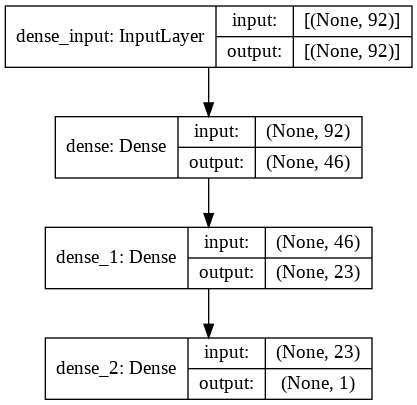

In [236]:
plot_model(nn, to_file='model_plot_nn.png', show_shapes=True, show_layer_names=True)

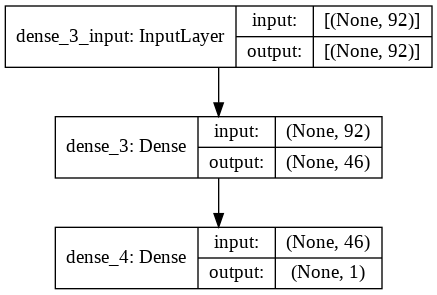

In [237]:
plot_model(nn_A1, to_file='model_plot_nn_A1.png', show_shapes=True, show_layer_names=True)

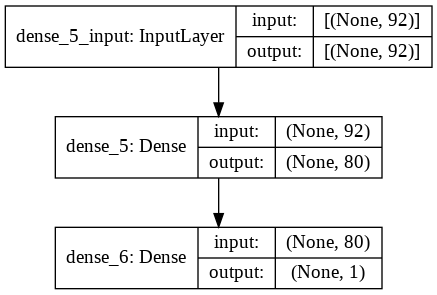

In [238]:
plot_model(nn_A2, to_file='model_plot_nn_A2.png', show_shapes=True, show_layer_names=True)

Prediction 1:  We will test a prediction on the first model for each of the two subgroups.  The first subgroup prediction is for "Number of Sales"

In [152]:
predictions = nn.predict(X_test)

In [157]:
# Instantiate the random oversampler model
# # Assign a random_state parameter of 1 to the model
# YOUR CODE HERE!
random_oversampler = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
# YOUR CODE HERE!
X_resampled, y_resampled = random_oversampler.fit_resample(X_train, y_train)

In [161]:
# Count the distinct values of the resampled labels data
# YOUR CODE HERE!
len(X_resampled)
len(y_resampled)

2602

In [164]:
nn.fit(X_resampled, y_resampled)
# Make a prediction using the testing data
# YOUR CODE HERE!
y_pred = nn.predict(X_test)

82/82 [==============================] - 0s 2ms/step - loss: 0.2549 - accuracy: 0.9151


Subgroup 2 - "Last Ethereum Price" group

In [196]:
# splitting the data
X_train_two, X_test_two, y_train_two, y_test_two = train_test_split(combined_df_nos, lsp_two, random_state = 1)

In [197]:
# Create a StandardScaler instance
scaler_two = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler_two = scaler_two.fit(X_train_two)

# Fit the scaler to the features training dataset
X_train_scaled_two = X_scaler_two.transform(X_train_two)
X_test_scaled_two = X_scaler.transform(X_test_two)

In [198]:
# Define the the number of inputs (features) to the model
number_input_features_two = len(X_train_two.iloc[0])

# Review the number of features
number_input_features_two

92

In [199]:
# Define the number of neurons in the output layer
number_output_neurons_two = 1

In [200]:
# Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1_two =  (number_input_features_two + number_output_neurons_two) // 2

# Review the number hidden nodes in the first layer
hidden_nodes_layer1_two

46

In [201]:
# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2_two = (hidden_nodes_layer1_two + number_output_neurons_two) // 2

# Review the number hidden nodes in the second layer
hidden_nodes_layer2_two

23

In [202]:
# Create the Sequential model instance
mm = Sequential()

In [203]:
# Add the first hidden layer
mm.add(Dense(units=hidden_nodes_layer1_two, input_dim=number_input_features_two, activation="relu"))

In [204]:
# Add the second hidden layer
mm.add(Dense(units=hidden_nodes_layer2_two, activation="relu"))

In [205]:
# Add the output layer to the model specifying the number of output neurons and activation function
mm.add(Dense(units=number_output_neurons_two, activation="sigmoid"))

In [206]:
# Display the Sequential model summary
mm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 46)                4278      
_________________________________________________________________
dense_8 (Dense)              (None, 23)                1081      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 24        
Total params: 5,383
Trainable params: 5,383
Non-trainable params: 0
_________________________________________________________________


In [207]:
# Compile the Sequential model
mm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [208]:
# Fit the model using 50 epochs and the training data
fit_model_two = mm.fit(X_train_scaled_two, y_train_two, epochs=50)

Epoch 1/50
67/67 [==============================] - 1s 3ms/step - loss: 0.6020 - accuracy: 0.6933
Epoch 2/50
67/67 [==============================] - 0s 2ms/step - loss: 0.4113 - accuracy: 0.8485
Epoch 3/50
67/67 [==============================] - 0s 2ms/step - loss: 0.3460 - accuracy: 0.8635
Epoch 4/50
67/67 [==============================] - 0s 2ms/step - loss: 0.3305 - accuracy: 0.8626
Epoch 5/50
67/67 [==============================] - 0s 1ms/step - loss: 0.3243 - accuracy: 0.8644
Epoch 6/50
67/67 [==============================] - 0s 2ms/step - loss: 0.3234 - accuracy: 0.8630
Epoch 7/50
67/67 [==============================] - 0s 2ms/step - loss: 0.3198 - accuracy: 0.8649
Epoch 8/50
67/67 [==============================] - 0s 2ms/step - loss: 0.3193 - accuracy: 0.8626
Epoch 9/50
67/67 [==============================] - 0s 1ms/step - loss: 0.3181 - accuracy: 0.8644
Epoch 10/50
67/67 [==============================] - 0s 1ms/step - loss: 0.3186 - accuracy: 0.8640
Epoch 11/50
67/67 [

In [ ]:
print("Original Model Results")

# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)

# Display the model loss and accuracy results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [209]:
# Define the the number of inputs (features) to the model
number_input_features_two = len(X_train.iloc[0])

# Review the number of features
number_input_features_two

92

In [210]:
# Define the number of neurons in the output layer
number_output_neurons_two_A1 = 1

In [211]:
# Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1_two_A1 = (number_input_features_two + number_output_neurons_two_A1) // 2

# Review the number of hidden nodes in the first layer
hidden_nodes_layer1_two_A1

46

In [212]:
# Create the Sequential model instance
mm_A1 = Sequential()

In [213]:
# First hidden layer
mm_A1.add(Dense(units=hidden_nodes_layer1_two_A1, input_dim=number_input_features_two, activation="relu"))

# Output layer
mm_A1.add(Dense(units=number_output_neurons_two_A1, activation="sigmoid"))

# Check the structure of the model
mm_A1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 46)                4278      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 47        
Total params: 4,325
Trainable params: 4,325
Non-trainable params: 0
_________________________________________________________________


In [214]:
# Compile the Sequential model
mm_A1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [215]:
# Fit the model using 50 epochs and the training data
fit_model_two_A1 = nn_A1.fit(X_train_scaled_two, y_train_two, epochs=50)

Epoch 1/50
67/67 [==============================] - 0s 1ms/step - loss: 1.1035 - accuracy: 0.6241
Epoch 2/50
67/67 [==============================] - 0s 1ms/step - loss: 0.4312 - accuracy: 0.7943
Epoch 3/50
67/67 [==============================] - 0s 1ms/step - loss: 0.3663 - accuracy: 0.8621
Epoch 4/50
67/67 [==============================] - 0s 2ms/step - loss: 0.3450 - accuracy: 0.8602
Epoch 5/50
67/67 [==============================] - 0s 2ms/step - loss: 0.3328 - accuracy: 0.8644
Epoch 6/50
67/67 [==============================] - 0s 1ms/step - loss: 0.3273 - accuracy: 0.8621
Epoch 7/50
67/67 [==============================] - 0s 1ms/step - loss: 0.3223 - accuracy: 0.8621
Epoch 8/50
67/67 [==============================] - 0s 1ms/step - loss: 0.3209 - accuracy: 0.8621
Epoch 9/50
67/67 [==============================] - 0s 1ms/step - loss: 0.3183 - accuracy: 0.8621
Epoch 10/50
67/67 [==============================] - 0s 2ms/step - loss: 0.3169 - accuracy: 0.8644
Epoch 11/50
67/67 [

Subgroup 2 - Alt Model 2

In [216]:
# Define the the number of inputs (features) to the model
number_input_features_two = len(X_train_two.iloc[0])

# Review the number of features
number_input_features_two

92

In [217]:

# Define the number of neurons in the output layer
number_output_neurons_two_A2 = 1

In [218]:
# Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1_two_A2 = 80

# Review the number of hidden nodes in the first layer
hidden_nodes_layer1_two_A2

80

In [219]:
# Create the Sequential model instance
mm_A2 = Sequential()

In [220]:
# First hidden layer
mm_A2.add(Dense(units=hidden_nodes_layer1_two_A2, input_dim=number_input_features_two, activation="relu"))

# Output layer
mm_A2.add(Dense(units=number_output_neurons_two_A2, activation="sigmoid"))

# Check the structure of the model
mm_A2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 80)                7440      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 81        
Total params: 7,521
Trainable params: 7,521
Non-trainable params: 0
_________________________________________________________________


In [221]:
# Compile the model
mm_A2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [222]:
# Fit the model
fit_model_two_A2 = mm_A2.fit(X_train_scaled_two, y_train_two, epochs=100)

Epoch 1/100
67/67 [==============================] - 1s 2ms/step - loss: 0.5332 - accuracy: 0.7340
Epoch 2/100
67/67 [==============================] - 0s 1ms/step - loss: 0.3661 - accuracy: 0.8597
Epoch 3/100
67/67 [==============================] - 0s 2ms/step - loss: 0.3352 - accuracy: 0.8630
Epoch 4/100
67/67 [==============================] - 0s 1ms/step - loss: 0.3274 - accuracy: 0.8630
Epoch 5/100
67/67 [==============================] - 0s 1ms/step - loss: 0.3238 - accuracy: 0.8616
Epoch 6/100
67/67 [==============================] - 0s 2ms/step - loss: 0.3209 - accuracy: 0.8644
Epoch 7/100
67/67 [==============================] - 0s 2ms/step - loss: 0.3202 - accuracy: 0.8626
Epoch 8/100
67/67 [==============================] - 0s 1ms/step - loss: 0.3181 - accuracy: 0.8644
Epoch 9/100
67/67 [==============================] - 0s 1ms/step - loss: 0.3175 - accuracy: 0.8644
Epoch 10/100
67/67 [==============================] - 0s 1ms/step - loss: 0.3163 - accuracy: 0.8630
Epoch 11/

Subgroup 2 - Comparing all 3 models

In [225]:
print("Original Model Results")

# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss_two, model_accuracy_two = mm.evaluate(X_test_scaled_two, y_test_two, verbose=2)

# Display the model loss and accuracy results
print(f"Loss: {model_loss_two}, Accuracy: {model_accuracy_two}")

Original Model Results
23/23 - 0s - loss: 0.5353 - accuracy: 0.8513
Loss: 0.5352886915206909, Accuracy: 0.851332426071167


In [226]:
print("Alternative Model 1 Results")

# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss_two_A1, model_accuracy_two_A1 = mm_A1.evaluate(X_test_scaled_two, y_test_two, verbose=2)

# Display the model loss and accuracy results
print(f"Loss: {model_loss_two_A1}, Accuracy: {model_accuracy_two_A1}")

Alternative Model 1 Results
23/23 - 0s - loss: 1.2691 - accuracy: 0.4123
Loss: 1.2691221237182617, Accuracy: 0.41234222054481506


In [227]:
print("Alternative Model 2 Results")

# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss_two_A2, model_accuracy_two_A2 = mm_A2.evaluate(X_test_scaled_two, y_test_two, verbose=2)

# Display the model loss and accuracy results
print(f"Loss: {model_loss_two_A2}, Accuracy: {model_accuracy_two_A2}")

Alternative Model 2 Results
23/23 - 0s - loss: 0.4633 - accuracy: 0.8555
Loss: 0.46326664090156555, Accuracy: 0.8555399775505066


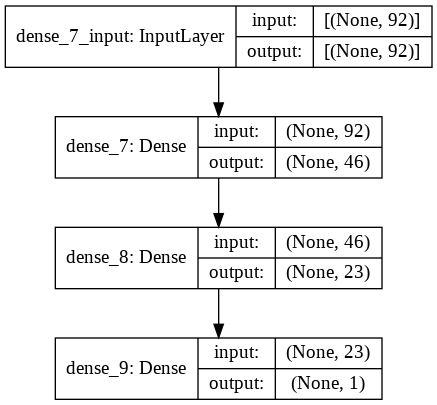

In [239]:
plot_model(mm, to_file='model_plot_mm.png', show_shapes=True, show_layer_names=True)

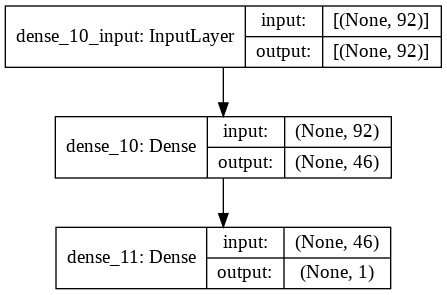

In [240]:
plot_model(mm_A1, to_file='model_plot_mm_A1.png', show_shapes=True, show_layer_names=True)

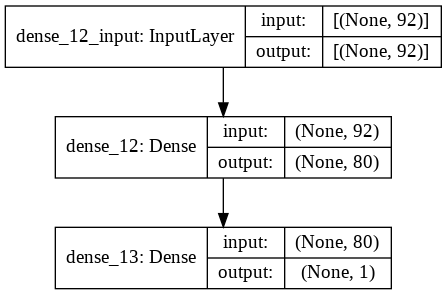

In [241]:
plot_model(mm_A2, to_file='model_plot_mm_A2.png', show_shapes=True, show_layer_names=True)

Prediction 2: The second prediction test for the "Last Ethereum Price" subgroup.

In [228]:
predictions_two = mm.predict(X_test_two)

In [229]:
# Instantiate the random oversampler model
# # Assign a random_state parameter of 1 to the model
# YOUR CODE HERE!
random_oversampler_two = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
# YOUR CODE HERE!
X_resampled_two, y_resampled_two = random_oversampler_two.fit_resample(X_train_two, y_train_two)

In [230]:
# Count the distinct values of the resampled labels data
# YOUR CODE HERE!
len(X_resampled_two)
len(y_resampled_two)

2148

In [231]:
mm.fit(X_resampled_two, y_resampled_two)
# Make a prediction using the testing data
# YOUR CODE HERE!
y_pred_two = mm.predict(X_test_two)

68/68 [==============================] - 0s 2ms/step - loss: 1.7221 - accuracy: 0.6029
